In [2]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/MyDrive/5153: Applied Machine Learning/LSTM Data


In [3]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [4]:
# READ IN ALL DATA
ticker = 'PLTR'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,272.0,95.0,367.0,25.885552,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,19.0,12.0,31.0,38.709553,0,291.0,145.5,NaN,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,341.0,130.0,471.0,27.600843,0,360.0,180.0,25.367647,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,239.0,67.0,306.0,21.895418,0,580.0,290.0,1157.894737,197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316741,0,0.275160
4,2021-01-05,59.0,57.0,116.0,49.137889,0,298.0,149.0,-82.697947,124.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.516378,1,-0.660916


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     321 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [6]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', '4D%Change', '3Dir', '5Dir', '7D%Change', '6D%Change', 'Dir', 'Low', '2D%Change', 'SD_log', '7Dir', 'High', 'SD', 'Open', '6Dir', '4Dir', '5D%Change', '3D%Change', '2Dir', 'Daily%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,High(t-1),SD(t-1),Open(t-1),6Dir(t-1),4Dir(t-1),5D%Change(t-1),3D%Change(t-1),2Dir(t-1),Daily%Change(t-1),Close(t-1)
7,25.500000,2,228.0,69.0,297.0,23.232315,277.0,138.5,776.923077,96.0,...,26.420000,1.044869,26.340000,1.0,1.0,6.422764,4.720001,1.0,0.964134,26.180000
8,24.920000,3,931.0,344.0,1275.0,26.980390,1159.0,579.5,1800.000000,413.0,...,27.430000,1.676605,25.709999,1.0,1.0,8.326249,1.190473,0.0,-2.597404,25.500000
9,25.639999,4,805.0,350.0,1155.0,30.303028,1736.0,868.0,253.070175,694.0,...,25.620001,1.078927,25.450001,1.0,0.0,-0.320000,-3.895103,0.0,-2.274510,24.920000
10,26.620001,1,140.0,46.0,186.0,24.731169,376.0,188.0,-79.411765,152.0,...,28.000000,4.151063,26.260000,1.0,0.0,1.746026,-2.062647,1.0,2.889243,25.639999
11,26.340000,2,213.0,80.0,293.0,27.303745,353.0,176.5,-9.745763,126.0,...,27.540001,2.452214,26.809999,1.0,1.0,2.661012,4.392160,1.0,3.822159,26.620001


In [7]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,High(t-1),SD(t-1),Open(t-1),6Dir(t-1),4Dir(t-1),5D%Change(t-1),3D%Change(t-1),2Dir(t-1),Daily%Change(t-1),Close(t-1)
225,20.590000,1,2.0,0.0,2.0,0.000000,4.0,2.0,100.0,1.0,...,21.570000,1.484895,21.530001,0.0,0.0,-11.789834,-8.181415,0.0,-3.549744,20.650000
226,21.110001,2,8.0,4.0,12.0,33.333056,10.0,5.0,300.0,4.0,...,21.049999,0.790879,20.590000,0.0,0.0,-10.981406,-4.232557,0.0,-0.290554,20.590000
227,21.030001,4,16.0,3.0,19.0,15.789391,297.0,148.5,100.0,65.0,...,21.200001,0.807769,20.350000,0.0,0.0,-6.136057,-1.401211,1.0,2.525500,21.110001
228,21.070000,0,41.0,13.0,54.0,24.074029,132.0,66.0,100.0,29.0,...,21.090000,1.072083,20.410000,0.0,0.0,-2.186043,1.840199,1.0,-0.378967,21.030001
237,18.940001,4,88.0,19.0,107.0,17.756993,88.0,44.0,100.0,19.0,...,20.150000,0.412392,19.950001,0.0,1.0,-2.437793,2.180850,0.0,-3.077702,19.209999


In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(132, 100)
(40, 100)


In [9]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(125, 7, 99) (125,)
(33, 7, 99) (33,)
0.0
0.8657294924649557


In [10]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.3591
Epoch 1: val_loss improved from inf to 0.01794, saving model to PLTR_Close_1shift_Sentiment.h5
8/8 [==============================] - 7s 427ms/step - loss: 0.3591 - val_loss: 0.0179
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0484
Epoch 2: val_loss did not improve from 0.01794
8/8 [==============================] - 2s 265ms/step - loss: 0.0484 - val_loss: 0.0217
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0255
Epoch 3: val_loss improved from 0.01794 to 0.00828, saving model to PLTR_Close_1shift_Sentiment.h5
8/8 [==============================] - 2s 303ms/step - loss: 0.0255 - val_loss: 0.0083
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0177
Epoch 4: val_loss did not improve from 0.00828
8/8 [==============================] - 2s 272ms/step - loss: 0.0177 - val_loss: 0.0105
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0

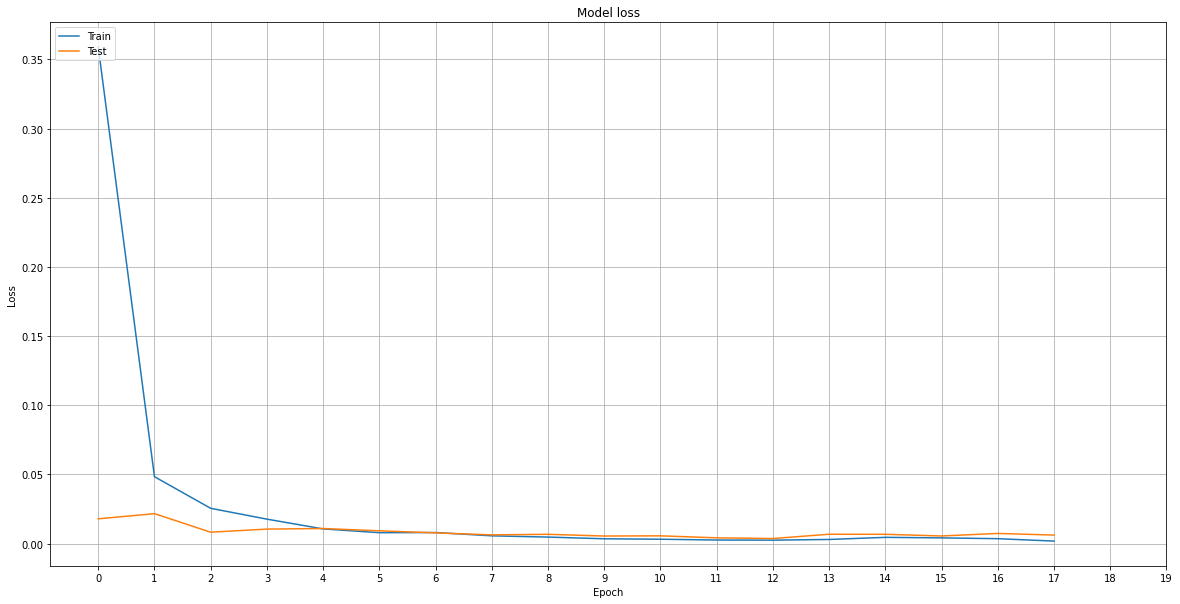

In [12]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [13]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 1.06
Mean Absolute Percentage Error (MAPE): 4.53 %
Median Absolute Percentage Error (MDAPE): 3.95 %


,MAE,MAPE,MDAPE
0,1.057614,4.529317,3.953669


In [14]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

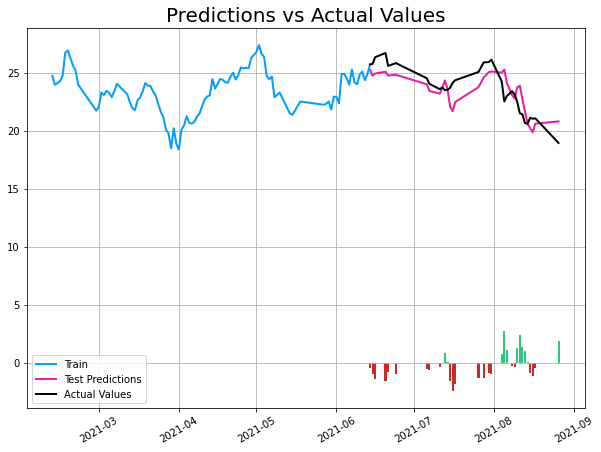

In [15]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [16]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', '4D%Change', '3Dir', '5Dir', '7D%Change', '6D%Change', 'Dir', 'Low', '2D%Change', 'SD_log', '7Dir', 'High', 'SD', 'Open', '6Dir', '4Dir', '5D%Change', '3D%Change', '2Dir', 'Daily%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,High(t-4),SD(t-4),Open(t-4),6Dir(t-4),4Dir(t-4),5D%Change(t-4),3D%Change(t-4),2Dir(t-4),Daily%Change(t-4),Close(t-4)
10,26.620001,1,2301.0,1084.0,3385.0,32.023633,3106.0,1553.0,147.153598,1434.0,...,26.420000,1.044869,26.340000,1.0,1.0,6.422764,4.720001,1.0,0.964134,26.180000
11,26.340000,2,680.0,323.0,1003.0,32.203387,2981.0,1490.5,-15.527950,1407.0,...,27.430000,1.676605,25.709999,1.0,1.0,8.326249,1.190473,0.0,-2.597404,25.500000
12,25.980000,3,236.0,106.0,342.0,30.994143,916.0,458.0,-89.743590,429.0,...,25.620001,1.078927,25.450001,1.0,0.0,-0.320000,-3.895103,0.0,-2.274510,24.920000
13,32.580002,4,140.0,46.0,186.0,24.731169,376.0,188.0,-79.411765,152.0,...,28.000000,4.151063,26.260000,1.0,0.0,1.746026,-2.062647,1.0,2.889243,25.639999
14,36.230000,0,150.0,51.0,201.0,25.373122,594.0,297.0,-29.577465,214.0,...,27.540001,2.452214,26.809999,1.0,1.0,2.661012,4.392160,1.0,3.822159,26.620001


In [17]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,High(t-4),SD(t-4),Open(t-4),6Dir(t-4),4Dir(t-4),5D%Change(t-4),3D%Change(t-4),2Dir(t-4),Daily%Change(t-4),Close(t-4)
230,19.379999,2,91.0,16.0,107.0,14.953257,91.0,45.5,468.75,16.0,...,21.200001,0.807769,20.35,0.0,0.0,-6.136057,-1.401211,1.0,2.525500,21.110001
231,19.690001,3,41.0,13.0,54.0,24.074029,132.0,66.0,100.00,29.0,...,21.090000,1.072083,20.41,0.0,0.0,-2.186043,1.840199,1.0,-0.378967,21.030001
238,18.400000,0,88.0,19.0,107.0,17.756993,88.0,44.0,100.00,19.0,...,19.855000,1.866077,19.26,0.0,1.0,-5.762715,-1.168113,1.0,3.510638,19.459999
239,18.639999,1,43.0,7.0,50.0,13.999972,131.0,65.5,100.00,26.0,...,19.825001,0.330744,19.51,0.0,1.0,2.270385,4.425712,1.0,1.849952,19.820000
249,18.170000,2,23.0,5.0,28.0,17.857079,23.0,11.5,100.00,5.0,...,19.450001,0.557224,18.65,1.0,1.0,0.106037,-0.944388,1.0,-0.105823,18.879999


In [18]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(121, 100)
(37, 100)


In [19]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(114, 7, 99) (114,)
(30, 7, 99) (30,)
0.75
0.8380998405981623


In [20]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.6234
Epoch 1: val_loss improved from inf to 0.03282, saving model to PLTR_Close_4shift_Sentiment.h5
8/8 [==============================] - 7s 416ms/step - loss: 0.6234 - val_loss: 0.0328
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0462
Epoch 2: val_loss did not improve from 0.03282
8/8 [==============================] - 2s 275ms/step - loss: 0.0462 - val_loss: 0.0361
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0328
Epoch 3: val_loss improved from 0.03282 to 0.02577, saving model to PLTR_Close_4shift_Sentiment.h5
8/8 [==============================] - 2s 305ms/step - loss: 0.0328 - val_loss: 0.0258
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0209
Epoch 4: val_loss improved from 0.02577 to 0.01447, saving model to PLTR_Close_4shift_Sentiment.h5
8/8 [==============================] - 2s 302ms/step - loss: 0.0209 - val_loss: 0.0145
Epoch 5/100
8/8 

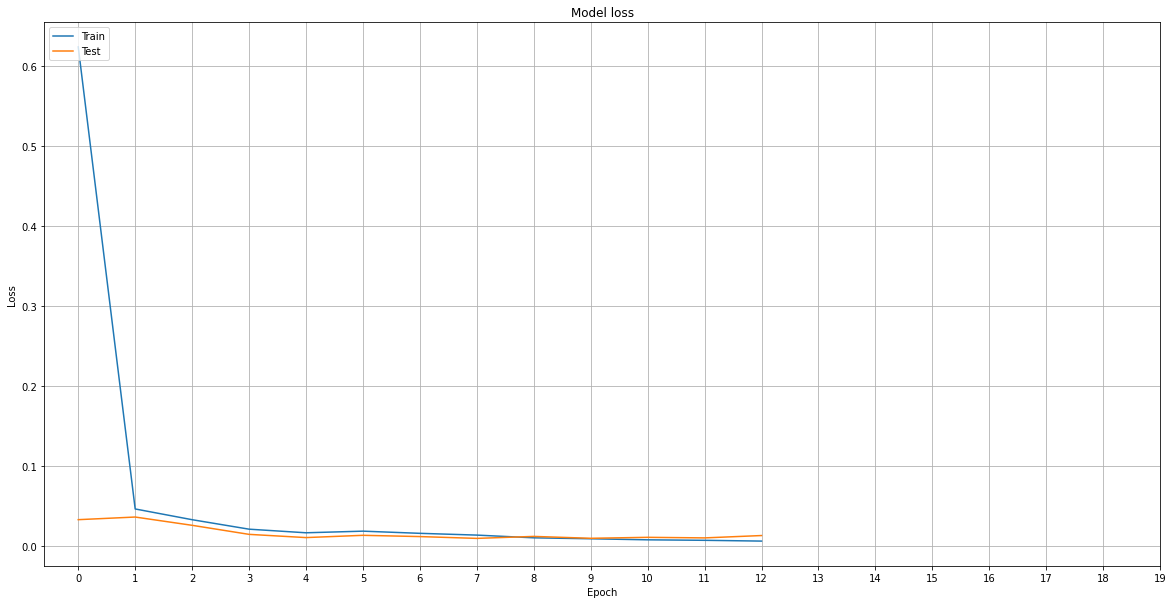

In [22]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.63
Mean Absolute Percentage Error (MAPE): 6.93 %
Median Absolute Percentage Error (MDAPE): 6.43 %


,MAE,MAPE,MDAPE
0,1.629445,6.929025,6.425209


In [24]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

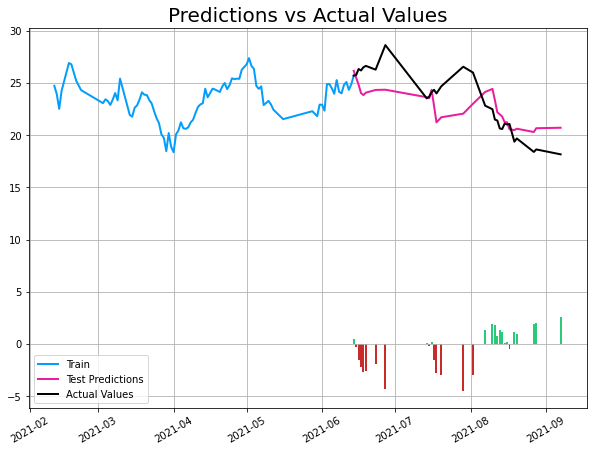

In [25]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [26]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', '4D%Change', '3Dir', '5Dir', '7D%Change', '6D%Change', 'Dir', 'Low', '2D%Change', 'SD_log', '7Dir', 'High', 'SD', 'Open', '6Dir', '4Dir', '5D%Change', '3D%Change', '2Dir', 'Daily%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,High(t-7),SD(t-7),Open(t-7),6Dir(t-7),4Dir(t-7),5D%Change(t-7),3D%Change(t-7),2Dir(t-7),Daily%Change(t-7),Close(t-7)
13,32.580002,4,2301.0,1084.0,3385.0,32.023633,3106.0,1553.0,147.153598,1434.0,...,26.420000,1.044869,26.340000,1.0,1.0,6.422764,4.720001,1.0,0.964134,26.180000
14,36.230000,0,140.0,46.0,186.0,24.731169,376.0,188.0,-79.411765,152.0,...,27.430000,1.676605,25.709999,1.0,1.0,8.326249,1.190473,0.0,-2.597404,25.500000
15,35.369999,1,213.0,80.0,293.0,27.303745,353.0,176.5,-9.745763,126.0,...,25.620001,1.078927,25.450001,1.0,0.0,-0.320000,-3.895103,0.0,-2.274510,24.920000
16,39.000000,2,444.0,163.0,607.0,26.853373,657.0,328.5,217.142857,243.0,...,28.000000,4.151063,26.260000,1.0,0.0,1.746026,-2.062647,1.0,2.889243,25.639999
17,35.660000,3,150.0,51.0,201.0,25.373122,594.0,297.0,-29.577465,214.0,...,27.540001,2.452214,26.809999,1.0,1.0,2.661012,4.392160,1.0,3.822159,26.620001


In [27]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,High(t-7),SD(t-7),Open(t-7),6Dir(t-7),4Dir(t-7),5D%Change(t-7),3D%Change(t-7),2Dir(t-7),Daily%Change(t-7),Close(t-7)
229,20.650000,1,8.0,4.0,12.0,33.333056,10.0,5.0,300.0,4.0,...,22.549999,1.618443,22.500000,0.0,0.0,-6.481078,-8.158906,0.0,-4.401955,21.500000
230,19.379999,2,281.0,62.0,343.0,18.075796,289.0,144.5,13950.0,66.0,...,21.959999,0.659240,21.600000,0.0,0.0,-6.219886,-7.436227,0.0,-0.418605,21.410000
231,19.690001,3,16.0,3.0,19.0,15.789391,297.0,148.5,100.0,65.0,...,21.570000,1.484895,21.530001,0.0,0.0,-11.789834,-8.181415,0.0,-3.549744,20.650000
241,18.340000,3,88.0,19.0,107.0,17.756993,88.0,44.0,100.0,19.0,...,19.855000,1.866077,19.260000,0.0,1.0,-5.762715,-1.168113,1.0,3.510638,19.459999
242,19.059999,4,43.0,7.0,50.0,13.999972,131.0,65.5,100.0,26.0,...,19.825001,0.330744,19.510000,0.0,1.0,2.270385,4.425712,1.0,1.849952,19.820000


In [28]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(132, 100)
(40, 100)


In [29]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(125, 7, 99) (125,)
(33, 7, 99) (33,)
0.25
0.6131846889546944


In [30]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.8386
Epoch 1: val_loss improved from inf to 0.04389, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 6s 403ms/step - loss: 0.8386 - val_loss: 0.0439
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0519
Epoch 2: val_loss improved from 0.04389 to 0.03321, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 2s 295ms/step - loss: 0.0519 - val_loss: 0.0332
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0211
Epoch 3: val_loss improved from 0.03321 to 0.02236, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 2s 304ms/step - loss: 0.0211 - val_loss: 0.0224
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0185
Epoch 4: val_loss improved from 0.02236 to 0.01899, saving model to PLTR_Close_7shift_Sentiment.h5
8/8 [==============================] - 2s 305ms/ste

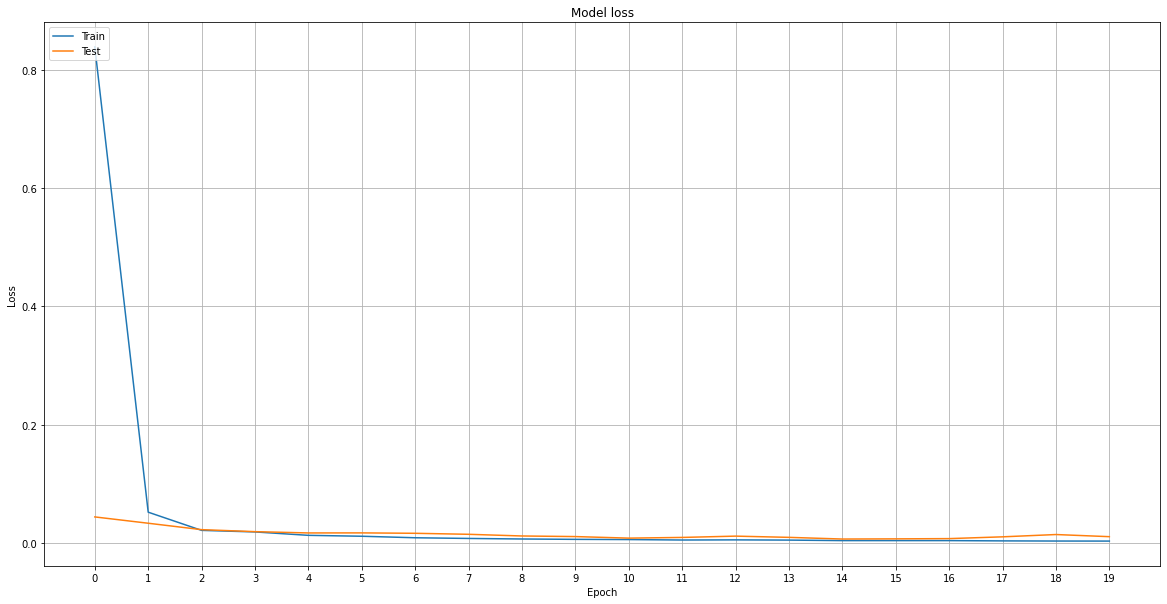

In [32]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.48
Mean Absolute Percentage Error (MAPE): 6.5 %
Median Absolute Percentage Error (MDAPE): 5.82 %


,MAE,MAPE,MDAPE
0,1.479207,6.496887,5.818495


In [34]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

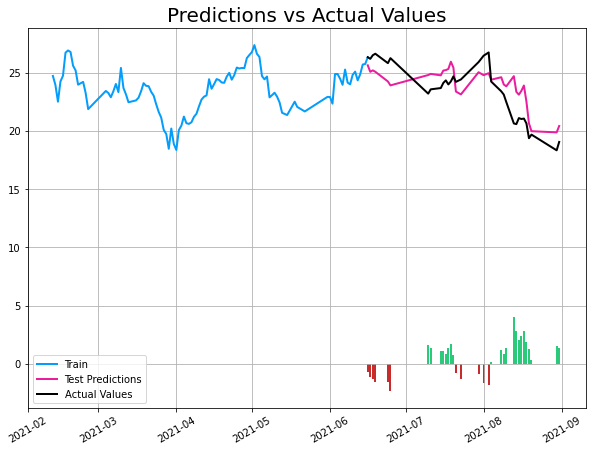

In [35]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [36]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', '4D%Change', '3Dir', '5Dir', '7D%Change', '6D%Change', 'Dir', 'Low', '2D%Change', 'SD_log', '7Dir', 'High', 'SD', 'Open', '6Dir', '4Dir', '5D%Change', '3D%Change', '2Dir', 'Daily%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,High(t-1),SD(t-1),Open(t-1),6Dir(t-1),4Dir(t-1),5D%Change(t-1),3D%Change(t-1),2Dir(t-1),Daily%Change(t-1),Close(t-1)
7,25.500000,2,297.0,373.0,186.5,828.125000,405.0,135.000000,66.853933,583.0,...,26.420000,1.044869,26.340000,1.0,1.0,6.422764,4.720001,1.0,0.964134,26.180000
8,24.920000,3,1275.0,1572.0,786.0,1577.631579,1648.0,549.333333,3884.375000,1680.0,...,27.430000,1.676605,25.709999,1.0,1.0,8.326249,1.190473,0.0,-2.597404,25.500000
9,25.639999,4,1155.0,2430.0,1215.0,288.888889,2727.0,909.000000,1419.736842,2803.0,...,25.620001,1.078927,25.450001,1.0,0.0,-0.320000,-3.895103,0.0,-2.274510,24.920000
10,26.620001,1,186.0,528.0,264.0,-81.455633,1531.0,510.333333,-94.505170,4916.0,...,28.000000,4.151063,26.260000,1.0,0.0,1.746026,-2.062647,1.0,2.889243,25.639999
11,26.340000,2,293.0,479.0,239.5,-14.327485,821.0,273.666667,-70.787637,1824.0,...,27.540001,2.452214,26.809999,1.0,1.0,2.661012,4.392160,1.0,3.822159,26.620001


In [37]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()


FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'comment_count_rollsum_4D(t-1)', 'comment_count_rollmean_4D(t-1)', 'comment_count_4D_pctchg(t-1)', 'comment_count_rollsum_5D(t-1)', 'comment_count_rollmean_5D(t-1)', 'comment_count_5D_pctchg(t-1)', 'comment_count_rollsum_6D(t-1)', 'comment_count_rollmean_6D(t-1)', 'comment_count_6D_pctchg(t-1)', 'comment_count_rollsum_7D(t-1)', 'comment_count_rollmean_7D(t-1)', 'comment_count_7D_pctchg(t-1)', 'is_meme(t-1)', 'Volume(t-1)', '4D%Change(t-1)', '3Dir(t-1)', '5Dir(t-1)', '7D%Change(t-1)', '6D%Change(t-1)', 'Dir(t-1)', 'Low(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '7Dir(t-1)', 'High(t-1)', 'SD(t-1)', 'Open(t-1)', '6Dir(t-1)', '4Dir(t-1)', '5D%Change(t-1)', '3D%Change(t-1)', '2Dir(t-1)', 'Daily%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,High(t-1),SD(t-1),Open(t-1),6Dir(t-1),4Dir(t-1),5D%Change(t-1),3D%Change(t-1),2Dir(t-1),Daily%Change(t-1),Close(t-1)
239,18.639999,1,2.0,2.0,1.0,100.000000,3.0,1.000000,-96.0,53.0,...,19.075001,0.946723,18.799999,0.0,0.0,-2.127658,-7.164481,0.0,-2.851114,18.400000
240,18.860001,2,1.0,3.0,1.5,100.000000,3.0,1.000000,0.0,4.0,...,18.858999,1.247906,18.000000,0.0,0.0,-4.213770,-2.967203,0.0,1.304347,18.639999
242,19.059999,4,1.0,1.0,0.5,0.000000,2.0,0.666667,-50.0,4.0,...,19.120001,0.880974,18.959999,0.0,0.0,-4.528886,-0.326084,0.0,-2.757160,18.340000
243,17.959999,0,2.0,2.0,1.0,-33.333333,5.0,1.666667,100.0,6.0,...,19.100000,0.939135,18.030001,0.0,1.0,0.633574,2.253219,1.0,3.925841,19.059999
248,18.570000,1,1.0,1.0,0.5,-96.428571,29.0,9.666667,100.0,29.0,...,19.250000,0.630860,18.780001,1.0,1.0,-0.629585,0.211645,1.0,0.052827,18.940001


In [38]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(166, 43)
(48, 43)


In [39]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(159, 7, 42) (159,)
(41, 7, 42) (41,)
0.0
0.8657294924649557


In [40]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0961
Epoch 1: val_loss improved from inf to 0.01681, saving model to PLTR_Close_1shift_Baseline.h5
10/10 [==============================] - 5s 155ms/step - loss: 0.0894 - val_loss: 0.0168
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0215
Epoch 2: val_loss improved from 0.01681 to 0.00598, saving model to PLTR_Close_1shift_Baseline.h5
10/10 [==============================] - 1s 67ms/step - loss: 0.0219 - val_loss: 0.0060
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0128
Epoch 3: val_loss improved from 0.00598 to 0.00413, saving model to PLTR_Close_1shift_Baseline.h5
10/10 [==============================] - 1s 73ms/step - loss: 0.0123 - val_loss: 0.0041
Epoch 4/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0113
Epoch 4: val_loss did not improve from 0.00413
10/10 [==============================] - 1s 57ms/step - loss: 0.0116 - val_loss: 0.0087
Epoch 

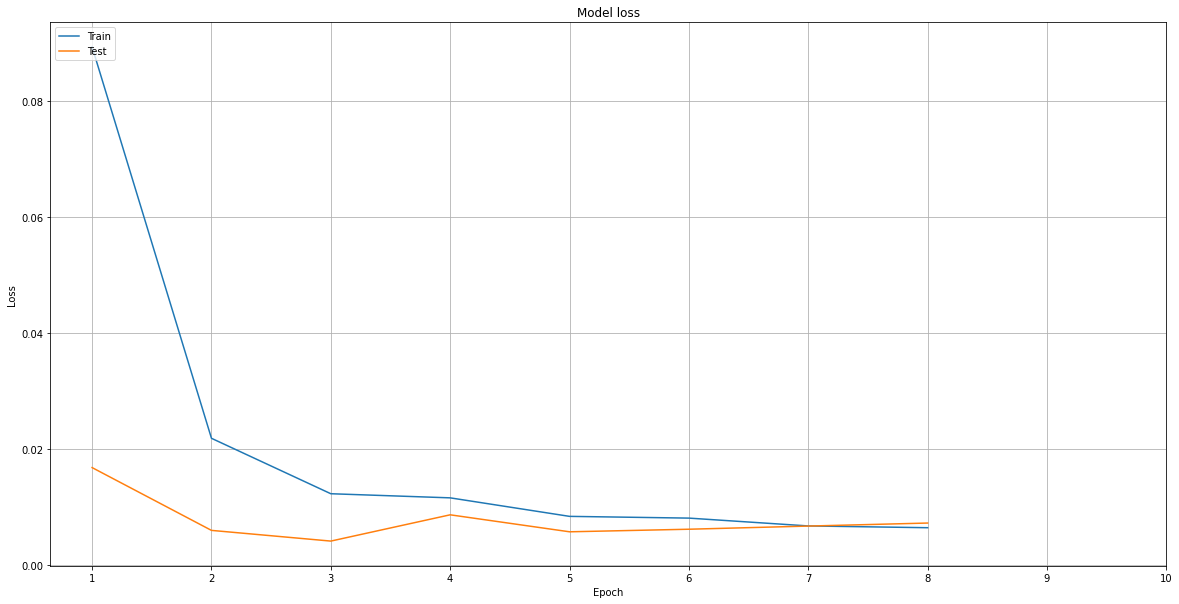

In [42]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [43]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 1.05
Mean Absolute Percentage Error (MAPE): 4.74 %
Median Absolute Percentage Error (MDAPE): 4.46 %


,MAE,MAPE,MDAPE
0,1.05304,4.744072,4.463992


In [44]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

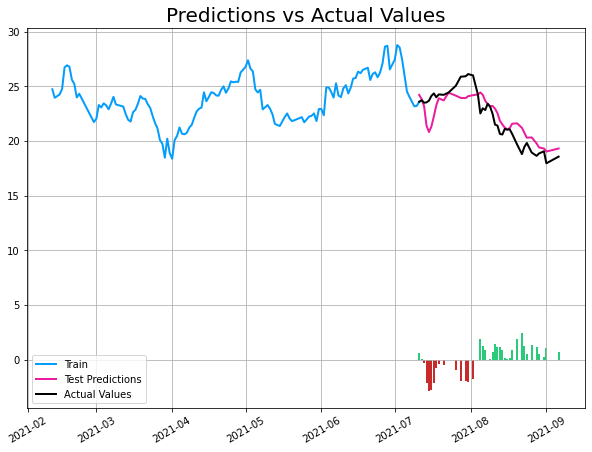

In [45]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [46]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', '4D%Change', '3Dir', '5Dir', '7D%Change', '6D%Change', 'Dir', 'Low', '2D%Change', 'SD_log', '7Dir', 'High', 'SD', 'Open', '6Dir', '4Dir', '5D%Change', '3D%Change', '2Dir', 'Daily%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,High(t-4),SD(t-4),Open(t-4),6Dir(t-4),4Dir(t-4),5D%Change(t-4),3D%Change(t-4),2Dir(t-4),Daily%Change(t-4),Close(t-4)
10,26.620001,1,3385.0,4540.0,2270.0,165.490196,5815.0,1938.333333,1039.730640,6112.0,...,26.420000,1.044869,26.340000,1.0,1.0,6.422764,4.720001,1.0,0.964134,26.180000
11,26.340000,2,1003.0,4388.0,2194.0,-13.160173,5543.0,1847.666667,-21.333333,6818.0,...,27.430000,1.676605,25.709999,1.0,1.0,8.326249,1.190473,0.0,-2.597404,25.500000
12,25.980000,3,342.0,1345.0,672.5,-89.896603,4730.0,1576.666667,-70.389610,5885.0,...,25.620001,1.078927,25.450001,1.0,0.0,-0.320000,-3.895103,0.0,-2.274510,24.920000
13,32.580002,4,186.0,528.0,264.0,-81.455633,1531.0,510.333333,-94.505170,4916.0,...,28.000000,4.151063,26.260000,1.0,0.0,1.746026,-2.062647,1.0,2.889243,25.639999
14,36.230000,0,201.0,808.0,404.0,-31.399317,1101.0,367.000000,8.064516,1287.0,...,27.540001,2.452214,26.809999,1.0,1.0,2.661012,4.392160,1.0,3.822159,26.620001


In [47]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'comment_count_rollsum_4D(t-4)', 'comment_count_rollmean_4D(t-4)', 'comment_count_4D_pctchg(t-4)', 'comment_count_rollsum_5D(t-4)', 'comment_count_rollmean_5D(t-4)', 'comment_count_5D_pctchg(t-4)', 'comment_count_rollsum_6D(t-4)', 'comment_count_rollmean_6D(t-4)', 'comment_count_6D_pctchg(t-4)', 'comment_count_rollsum_7D(t-4)', 'comment_count_rollmean_7D(t-4)', 'comment_count_7D_pctchg(t-4)', 'is_meme(t-4)', 'Volume(t-4)', '4D%Change(t-4)', '3Dir(t-4)', '5Dir(t-4)', '7D%Change(t-4)', '6D%Change(t-4)', 'Dir(t-4)', 'Low(t-4)', '2D%Change(t-4)', 'SD_log(t-4)', '7Dir(t-4)', 'High(t-4)', 'SD(t-4)', 'Open(t-4)', '6Dir(t-4)', '4Dir(t-4)', '5D%Change(t-4)', '3D%Change(t-4)', '2Dir(t-4)', 'Daily%Change(t-4)', 'Close(t-4)']


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,High(t-4),SD(t-4),Open(t-4),6Dir(t-4),4Dir(t-4),5D%Change(t-4),3D%Change(t-4),2Dir(t-4),Daily%Change(t-4),Close(t-4)
242,19.059999,4,2.0,2.0,1.0,100.000000,3.0,1.000000,-96.0,53.0,...,19.075001,0.946723,18.799999,0.0,0.0,-2.127658,-7.164481,0.0,-2.851114,18.400000
243,17.959999,0,1.0,1.0,0.5,0.000000,2.0,0.666667,-50.0,4.0,...,18.858999,1.247906,18.000000,0.0,0.0,-4.213770,-2.967203,0.0,1.304347,18.639999
244,18.900000,1,3.0,4.0,2.0,100.000000,4.0,1.333333,200.0,5.0,...,18.940001,1.467593,18.370001,0.0,0.0,-4.843588,-0.422386,1.0,1.180264,18.860001
246,18.930000,3,2.0,2.0,1.0,-33.333333,5.0,1.666667,100.0,6.0,...,19.100000,0.939135,18.030001,0.0,1.0,0.633574,2.253219,1.0,3.925841,19.059999
249,18.170000,2,28.0,28.0,14.0,100.000000,28.0,9.333333,100.0,28.0,...,19.450001,0.557224,18.650000,1.0,1.0,0.106037,-0.944388,1.0,-0.105823,18.879999


In [48]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(160, 43)
(46, 43)


In [49]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(153, 7, 42) (153,)
(39, 7, 42) (39,)
0.75
0.8380998405981623


In [50]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.1178
Epoch 1: val_loss improved from inf to 0.03254, saving model to PLTR_Close_4shift_Baseline.h5
10/10 [==============================] - 5s 152ms/step - loss: 0.1115 - val_loss: 0.0325
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0274
Epoch 2: val_loss improved from 0.03254 to 0.00701, saving model to PLTR_Close_4shift_Baseline.h5
10/10 [==============================] - 1s 66ms/step - loss: 0.0280 - val_loss: 0.0070
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0125
Epoch 3: val_loss did not improve from 0.00701
10/10 [==============================] - 1s 55ms/step - loss: 0.0125 - val_loss: 0.0152
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0105
Epoch 4: val_loss did not improve from 0.00701
10/10 [==============================] - 1s 58ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 5/100
 9/10 [==========================>...] - ETA:

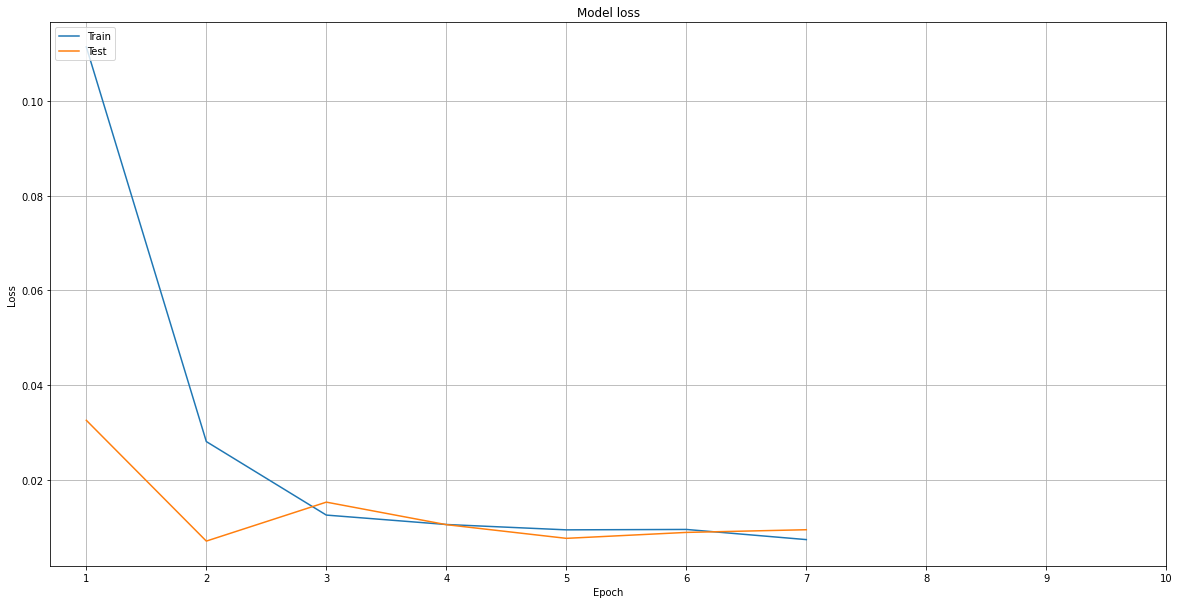

In [52]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [53]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 1.55
Mean Absolute Percentage Error (MAPE): 7.22 %
Median Absolute Percentage Error (MDAPE): 7.02 %


,MAE,MAPE,MDAPE
0,1.550787,7.221776,7.021045


In [54]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

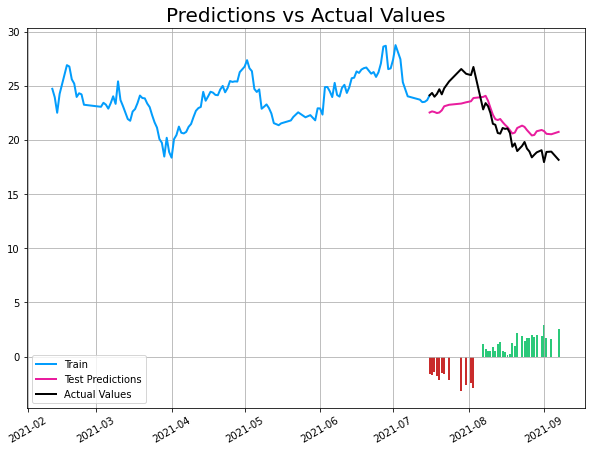

In [55]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [56]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Volume', '4D%Change', '3Dir', '5Dir', '7D%Change', '6D%Change', 'Dir', 'Low', '2D%Change', 'SD_log', '7Dir', 'High', 'SD', 'Open', '6Dir', '4Dir', '5D%Change', '3D%Change', '2Dir', 'Daily%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,High(t-7),SD(t-7),Open(t-7),6Dir(t-7),4Dir(t-7),5D%Change(t-7),3D%Change(t-7),2Dir(t-7),Daily%Change(t-7),Close(t-7)
13,32.580002,4,3385.0,4540.0,2270.0,165.490196,5815.0,1938.333333,1039.730640,6112.0,...,26.420000,1.044869,26.340000,1.0,1.0,6.422764,4.720001,1.0,0.964134,26.180000
14,36.230000,0,186.0,528.0,264.0,-81.455633,1531.0,510.333333,-94.505170,4916.0,...,27.430000,1.676605,25.709999,1.0,1.0,8.326249,1.190473,0.0,-2.597404,25.500000
15,35.369999,1,293.0,479.0,239.5,-14.327485,821.0,273.666667,-70.787637,1824.0,...,25.620001,1.078927,25.450001,1.0,0.0,-0.320000,-3.895103,0.0,-2.274510,24.920000
16,39.000000,2,607.0,900.0,450.0,226.344086,1086.0,362.000000,77.485380,1428.0,...,28.000000,4.151063,26.260000,1.0,0.0,1.746026,-2.062647,1.0,2.889243,25.639999
17,35.660000,3,201.0,808.0,404.0,-31.399317,1101.0,367.000000,8.064516,1287.0,...,27.540001,2.452214,26.809999,1.0,1.0,2.661012,4.392160,1.0,3.822159,26.620001


In [57]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'comment_count_rollsum_4D(t-7)', 'comment_count_rollmean_4D(t-7)', 'comment_count_4D_pctchg(t-7)', 'comment_count_rollsum_5D(t-7)', 'comment_count_rollmean_5D(t-7)', 'comment_count_5D_pctchg(t-7)', 'comment_count_rollsum_6D(t-7)', 'comment_count_rollmean_6D(t-7)', 'comment_count_6D_pctchg(t-7)', 'comment_count_rollsum_7D(t-7)', 'comment_count_rollmean_7D(t-7)', 'comment_count_7D_pctchg(t-7)', 'is_meme(t-7)', 'Volume(t-7)', '4D%Change(t-7)', '3Dir(t-7)', '5Dir(t-7)', '7D%Change(t-7)', '6D%Change(t-7)', 'Dir(t-7)', 'Low(t-7)', '2D%Change(t-7)', 'SD_log(t-7)', '7Dir(t-7)', 'High(t-7)', 'SD(t-7)', 'Open(t-7)', '6Dir(t-7)', '4Dir(t-7)', '5D%Change(t-7)', '3D%Change(t-7)', '2Dir(t-7)', 'Daily%Change(t-7)', 'Close(t-7)']


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,High(t-7),SD(t-7),Open(t-7),6Dir(t-7),4Dir(t-7),5D%Change(t-7),3D%Change(t-7),2Dir(t-7),Daily%Change(t-7),Close(t-7)
241,18.340000,3,107.0,107.0,53.5,10600.0,108.0,36.000000,5250.0,110.0,...,19.855000,1.866077,19.260000,0.0,1.0,-5.762715,-1.168113,1.0,3.510638,19.459999
242,19.059999,4,50.0,157.0,78.5,100.0,157.0,52.333333,4900.0,158.0,...,19.825001,0.330744,19.510000,0.0,1.0,2.270385,4.425712,1.0,1.849952,19.820000
243,17.959999,0,2.0,2.0,1.0,100.0,3.0,1.000000,-96.0,53.0,...,20.150000,0.412392,19.950001,0.0,1.0,-2.437793,2.180850,0.0,-3.077702,19.209999
244,18.900000,1,1.0,3.0,1.5,100.0,3.0,1.000000,0.0,4.0,...,19.580000,0.694337,19.280001,0.0,1.0,-0.210743,-2.672141,0.0,-1.405510,18.940001
246,18.930000,3,1.0,1.0,0.5,0.0,2.0,0.666667,-50.0,4.0,...,18.858999,1.247906,18.000000,0.0,0.0,-4.213770,-2.967203,0.0,1.304347,18.639999


In [58]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(165, 43)
(48, 43)


In [59]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


(158, 7, 42) (158,)
(41, 7, 42) (41,)
0.25
0.6131846889546944


In [60]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.0630
Epoch 1: val_loss improved from inf to 0.02880, saving model to PLTR_Close_7shift_Baseline.h5
10/10 [==============================] - 5s 161ms/step - loss: 0.0630 - val_loss: 0.0288
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0178
Epoch 2: val_loss improved from 0.02880 to 0.01829, saving model to PLTR_Close_7shift_Baseline.h5
10/10 [==============================] - 1s 63ms/step - loss: 0.0191 - val_loss: 0.0183
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0123
Epoch 3: val_loss did not improve from 0.01829
10/10 [==============================] - 1s 57ms/step - loss: 0.0123 - val_loss: 0.0248
Epoch 4/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0092
Epoch 4: val_loss did not improve from 0.01829
10/10 [==============================] - 1s 56ms/step - loss: 0.0091 - val_loss: 0.0311
Epoch 5/100
 9/10 [==========================>...] - ETA:

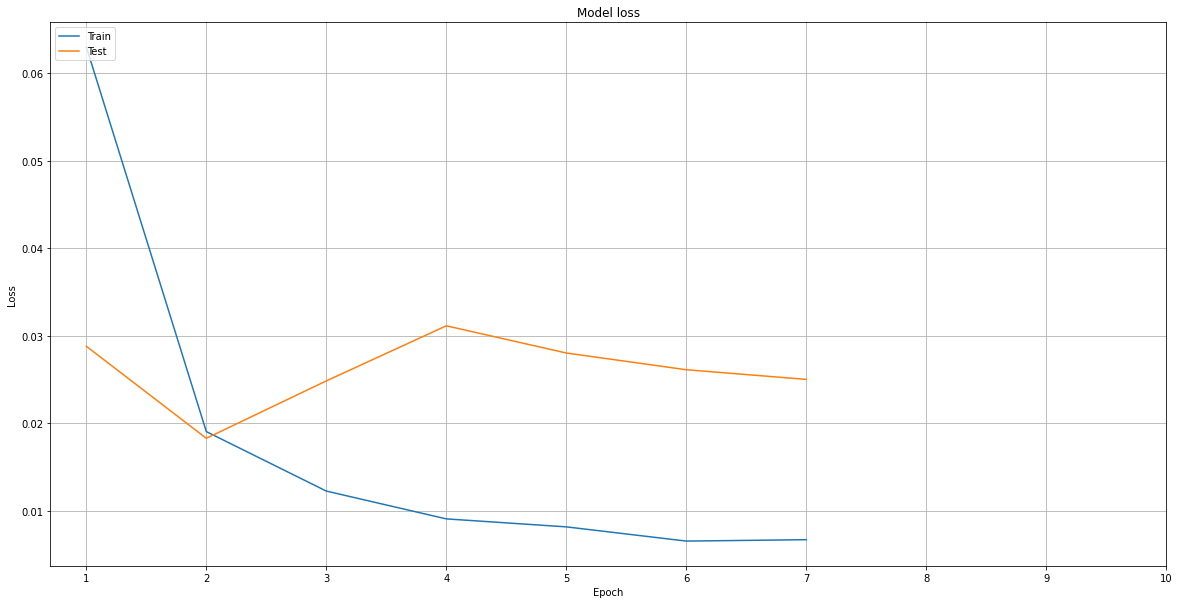

In [62]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [63]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 2.43
Mean Absolute Percentage Error (MAPE): 11.01 %
Median Absolute Percentage Error (MDAPE): 11.27 %


,MAE,MAPE,MDAPE
0,2.429944,11.014282,11.273696


In [64]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

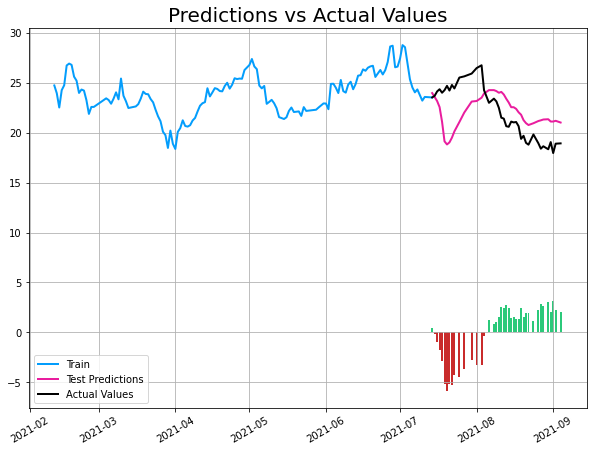

In [65]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## Overall Results

In [66]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,1.053040,1.057614
1,1dayshift,MAPE,4.744072,4.529317
2,1dayshift,MDAPE,4.463992,3.953669
3,4dayshift,MAE,1.550787,1.629445
4,4dayshift,MAPE,7.221776,6.929025
5,4dayshift,MDAPE,7.021045,6.425209
6,7dayshift,MAE,2.429944,1.479207
7,7dayshift,MAPE,11.014282,6.496887
8,7dayshift,MDAPE,11.273696,5.818495


In [67]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)